<a href="https://colab.research.google.com/github/Laexey/DataScianceLearn/blob/master/TimeSeries/%D0%92%D1%80_%D1%80%D1%8F%D0%B4%D1%8B_%D0%94%D0%97_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from datetime import datetime
from sklearn.model_selection import TimeSeriesSplit
%matplotlib inline
plt.rcParams['figure.figsize'] = (18,4)

In [226]:
!ls 'drive/My Drive/Projects/TimeSeries'

daily-total-female-births-in-cal.csv  monthly-boston-armed-robberies-j.csv
international-airline-passengers.csv  monthly-sales-of-company-x-jan-6.csv
mean-monthly-air-temperature-deg.csv  weekly-closings-of-the-dowjones-.csv


##1. Приведение графика в стационарную форму

**Для изучения взят график продаж по месяцам компании X**

In [0]:
time_stamp = pd.read_csv('drive/My Drive/Projects/TimeSeries/monthly-sales-of-company-x-jan-6.csv', index_col='Month', parse_dates=True, dayfirst=True)

In [228]:
time_stamp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 77 entries, 1965-01-01 to 1971-05-01
Data columns (total 1 columns):
Count    77 non-null int64
dtypes: int64(1)
memory usage: 1.2 KB


In [229]:
time_stamp.tail()

,Count
Month,
1971-01-01,628
1971-02-01,308
1971-03-01,324
1971-04-01,248
1971-05-01,272


In [0]:
ts = time_stamp.copy()

**На графике видна мультипликативная сезонность, а так же тренд. Таким образом, ряд не стационарный.**

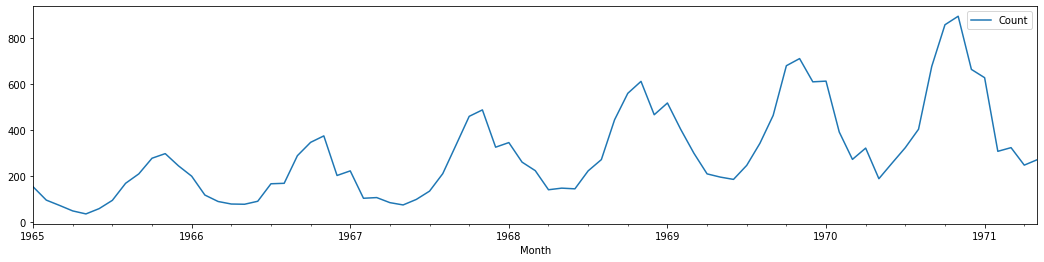

In [231]:
ts.plot()

In [232]:
ts.Count.autocorr()

0.8745190140938308

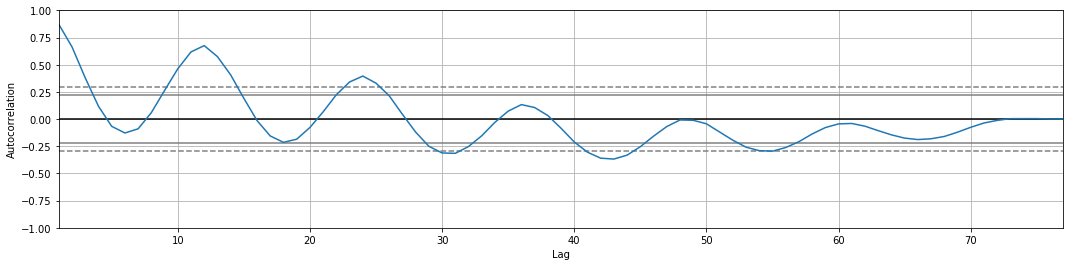

In [233]:

pd.plotting.autocorrelation_plot(ts)

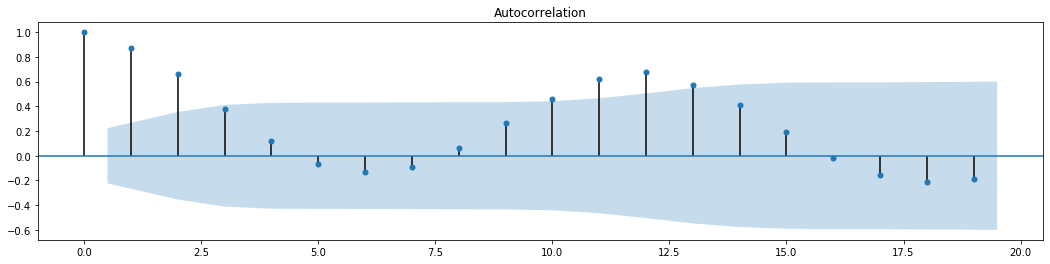

In [234]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ts.dropna());

**Для того, чтобы убрать мультипликативную составляющюю, воспользуемся методом Бокса Кокса.**



In [0]:
tsbc = boxcox(ts.Count)

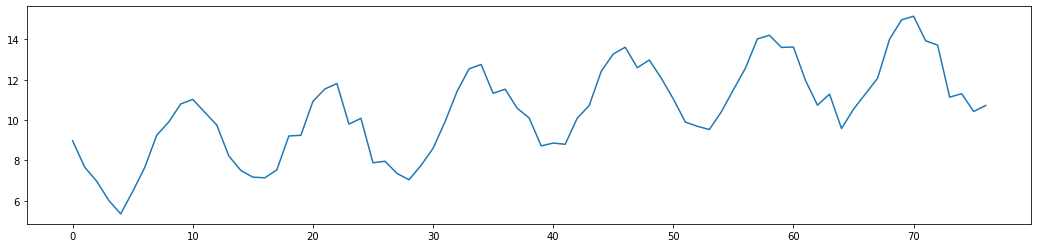

In [236]:
plt.plot(tsbc[0])

**Тест Дики-Фуллера показывает высокое значение p-value, что подтверждает факт о нестационарности ряда (визуально это так же очевидно)**

In [237]:
adfuller(tsbc[0])[1]

0.863756586766914

**Возьмем разность исходного массива для n=1**

In [0]:
import numpy as np

In [0]:
ts2=np.diff(tsbc[0], n=1)

**Тест показал, что результат оказался приемлемым**

In [240]:
adfuller(ts2)[1]

0.015599469714685253

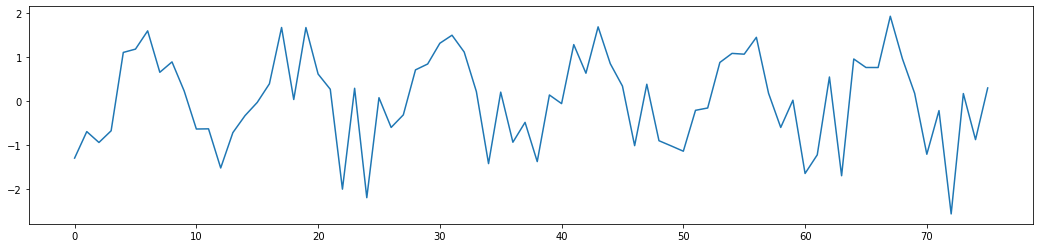

In [241]:

plt.plot(ts2)

**Однако, кореллограмма показывает не убедительный результат, который мало отличается от исходного варианта последовательности.**

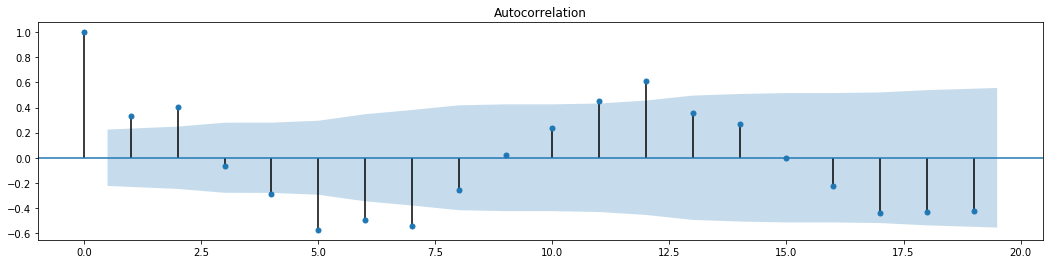

In [242]:
plot_acf(ts2);

**Берем еще одну разность. Теперь график выглядит более хаотичным. Ниже проведена проверка методом Дики-Фуллера, а так же построена кореллограмма, чтобы убедиться в стационарности ряда**

In [0]:
ts3=np.diff(ts2, n=1)

In [244]:
adfuller(ts3)[1]

4.978931024877979e-11

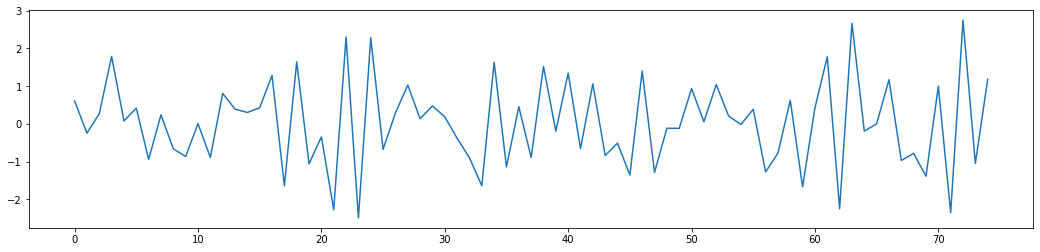

In [245]:
plt.plot(ts3)

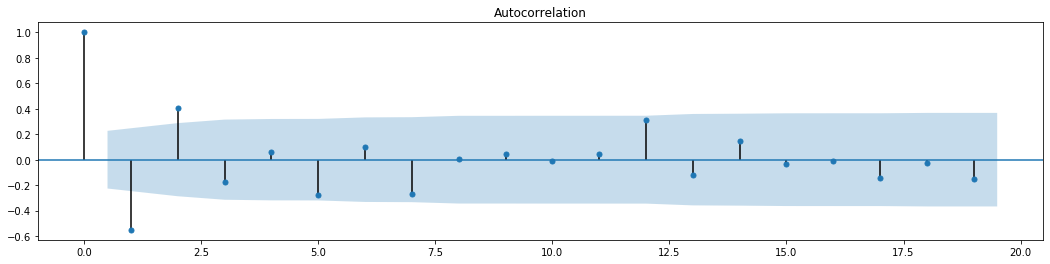

In [246]:
plot_acf(ts3);

**Визуально так же можно сделать вывод от хаотичности ряда, что позволяет дальше строить модель для предсказания**

##2. Приближение изучаемого ряда различными моделями как в стационарной, так и не в стационарной формах.

In [0]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

**Ниже построен график ряда в нестационарной форме, для оригинального ряда, и для приближенного скользящим средним, а так же вычислена среднеквадратичная ошибка между ними.**

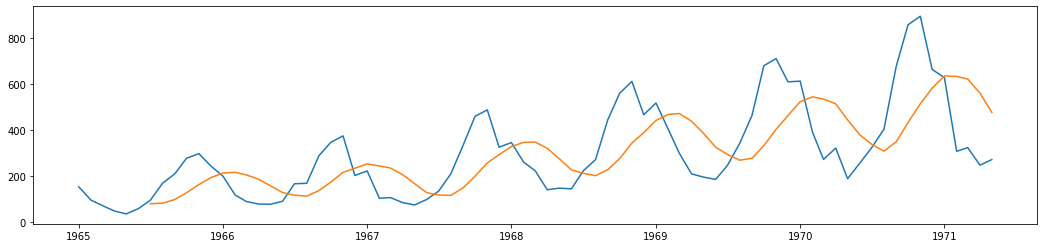

In [248]:
plt.plot(ts)
plt.plot(ts.rolling(7).mean())

In [249]:
mean_squared_error(ts[6:], ts.rolling(7).mean().dropna())

30043.957746478874

**Аналогично, график и среднеквадратичная ошибка для оригинального ряда и приближенного в стационарной форме**

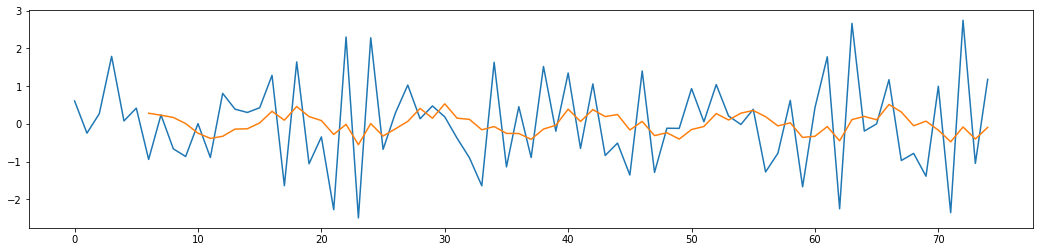

In [250]:
plt.plot(ts3)
plt.plot(pd.Series(ts3).rolling(7).mean())

In [251]:
mean_squared_error(ts3[6:],pd.Series(ts3).rolling(7).mean().dropna())

1.3157828510291074

**Вычисление ошибки для модели, полученной взвешенным скользящим средним. В качестве весов выбраны степени двойки. Видно существенное улучшение результата.**

In [0]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return pd.Series([np.NaN]).append(wma, ignore_index=True)

In [253]:
mean_squared_error(ts.Count[6:], weighted_moving_average(ts.Count, 7, [2,4,8,16,32,64,128]).dropna())

4674.593404933288

In [254]:
mean_squared_error(ts3[6:],weighted_moving_average(ts3, 7, [2,4,8,16,32, 64, 128]).dropna())

0.5886406678059072

**Экспоненциальная модель. Нестационарный ряд существенно улучшился, а в стационарном варианте пошло ухудшение качества.**

In [0]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [0]:
train, test = ts.Count[:int(len(ts.Count)*0.7)], ts.Count[int(len(ts.Count)*0.7):]
def mse(X):
    a = X
    result = exponential_moving_average(train, a)
    predict = result[-len(test):]
    return mean_squared_error(predict, test)
  
opt = minimize(mse, x0=[0], method="L-BFGS-B")
a_opt = opt.x

In [257]:
mean_squared_error(ts.Count[6:], exponential_moving_average(ts.Count, a_opt)[6:])

723.7156010784812

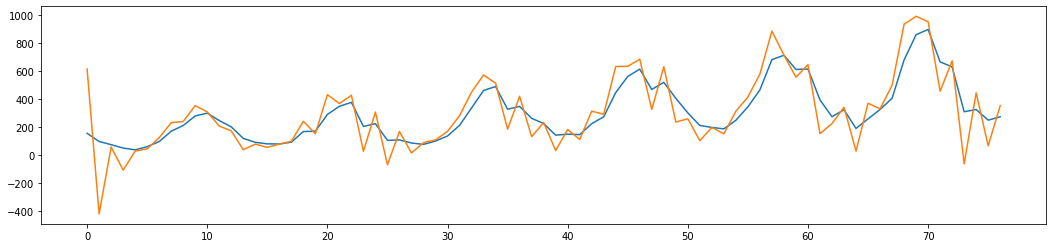

In [258]:
plt.plot(ts.reset_index().drop('Month', axis=1))
plt.plot(double_ema(ts.Count, a_opt, b_opt))

In [0]:
train, test = ts3[:int(len(ts3)*0.7)], ts3[int(len(ts3)*0.7):]

opt = minimize(mse, x0=[0], method="L-BFGS-B")
a_opt = opt.x


In [260]:
mean_squared_error(ts3[6:], exponential_moving_average(ts3, a_opt)[6:])

0.8741572627416603

**Двойное экспоненциальное сглаживание. Тут пошло сильное ухудшение для обоих, нестационарного и стационарного вариантов, при этом визуально складывается впечатление, что модель идеально ложится в оригинал, за исключением первых 6 значений для нестационарного варианта.**

In [0]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)
    

In [0]:
train, test = ts.Count[:int(len(ts.Count)*0.7)], ts.Count[int(len(ts.Count)*0.7):]
def mse(X):
    a, b = X
    result = double_ema(train, a, b)
    predict = result[-len(test):]
    return mean_squared_error(predict, test)
  
opt = minimize(mse, x0=[0, 0], method="L-BFGS-B", bounds=((0,1),(0,1)))
a_opt, b_opt = opt.x

In [263]:
mean_squared_error(ts.Count[6:], double_ema(ts.Count[6:], a_opt, b_opt))

17927.50146720579

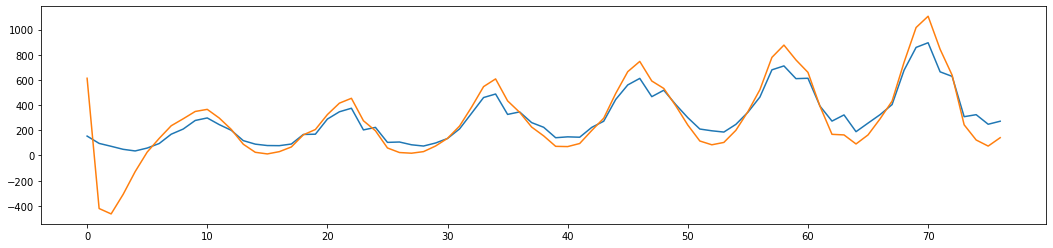

In [264]:
plt.plot(ts.reset_index().drop('Month', axis=1))
plt.plot(double_ema(ts.Count, a_opt, b_opt))

In [0]:
train, test = ts3[:int(len(ts3)*0.7)], ts3[int(len(ts3)*0.7):]
  
opt = minimize(mse, x0=[0, 0], method="L-BFGS-B", bounds=((0,1),(0,1)))
a_opt, b_opt = opt.x


In [266]:
mean_squared_error(ts3[6:], double_ema(ts3[6:], a_opt, b_opt))

1.0608087749431225

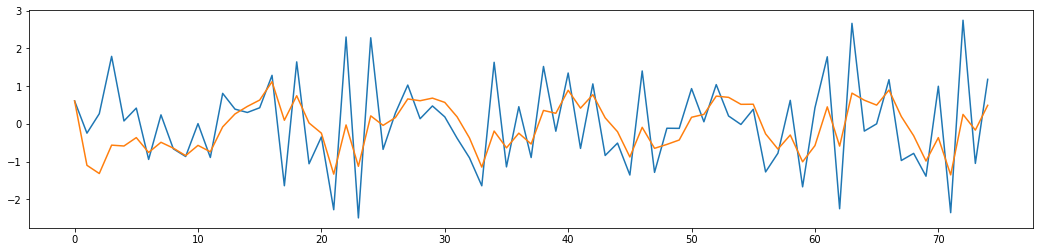

In [267]:
plt.plot(ts3)
plt.plot(double_ema(ts3, a_opt, b_opt))

**Так как ряд имеет сезонность, можно применить метод Хольта-Винтерса. Результат оказался лучше двойного экспоненциального сглаживания для стационарного варианта, однако при этом несколько хуже экспоненциального сглаживания. При этом, визуально, моедль прекрасно подходит.**
**В стационарном варианте модель сильно лучше всех остальных, исследованных ранее.**

In [0]:
def initial_trend(series, season_len, i=0):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len
  
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result


In [0]:
train, test = ts.Count[:int(len(ts.Count)*0.7)], ts.Count[int(len(ts.Count)*0.7):]

def mse(X):
    a, b, g = X
    result = triple_exponential_smoothing(train, 12, a, b, g, 0)
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error
  
opt = minimize(mse, x0=[0, 0, 0], method="L-BFGS-B", bounds=((0,1),(0,1),(0,1)))
a_opt, b_opt, g_opt = opt.x

In [287]:
mean_squared_error(ts.Count.reset_index().drop('Month', axis=1)[10:], triple_exponential_smoothing(ts.Count, 12, a_opt, b_opt, g_opt, 0)[10:])

1010.5490203710997

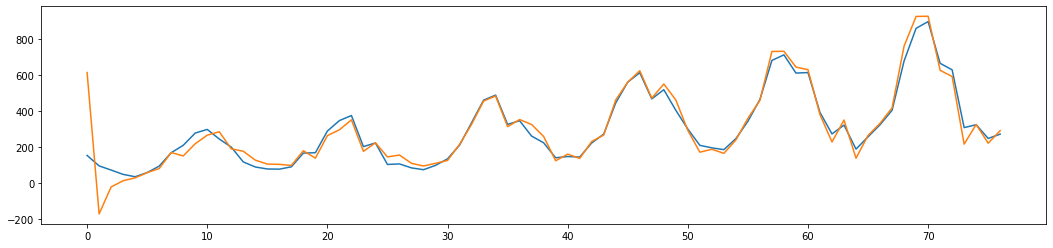

In [291]:
plt.plot(ts.Count.reset_index().drop('Month', axis=1))
plt.plot(triple_exponential_smoothing(ts.Count, 12, a_opt, b_opt, g_opt, 0))

In [0]:
train, test = ts3[:int(len(ts3)*0.7)], ts3[int(len(ts3)*0.7):]

def mse(X):
    a, b, g = X
    result = triple_exponential_smoothing(train, 12, a, b, g, 0)
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error
  
opt = minimize(mse, x0=[0, 0, 0], method="L-BFGS-B", bounds=((0,1),(0,1),(0,1)))
a_opt, b_opt, g_opt = opt.x

In [293]:
mean_squared_error(test, triple_exponential_smoothing(test, 12, a_opt, b_opt, g_opt, 0))

0.39256073782056405

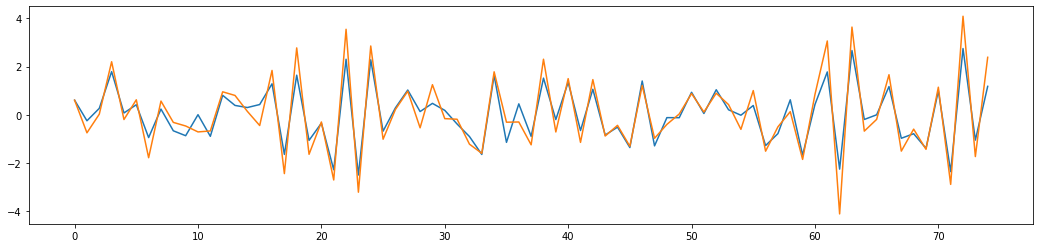

In [295]:
plt.plot(ts3)
plt.plot(triple_exponential_smoothing(ts3, 12, a_opt, b_opt, g_opt, 0))
